#Problem Set 2 Number 4: Weak Instruments

##Construct a data-generating process

In [16]:
#Import packages
import numpy as np
import pandas as pd
import scipy.stats.distributions as iid
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt

In [28]:
# DGP: y, X, z

def dgp(N, beta, pi):
    '''
    Data-generating process
    
    Inputs
    ------
    N (int) number of obervations
    beta (float) true parameter
    pi (lx1 np.array) tur first stage parameter
 
    Returns
    -------
    y (Nx1 np.array)
    x (Nx1 np.array)
    Z (Nxl np.array)
    '''
    
    
    # infer number of instruments from the size of pi
    l = pi.shape[0]
    # first generate Z
    Z = scipy.stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    if len(Z.shape) == 1:
        Z = Z.reshape(-1,1)
    
    # now build X
    X = Z@pi + iid.norm().rvs(size=(N,1))

    # finally, build y
    y = X*beta + iid.norm().rvs(size=(N,1))
    
    return y, X, Z

In [6]:
# test IV regression
N = 100
beta = 2

for p in [0.00001, 0.001, 0.1, 1, 500]:
    # set pi
    pi = np.array([[p]])
    # generate data
    y, X, Z = dgp(N, beta, pi)
    # estimate beta via IV
    bhat = np.linalg.solve(Z.T@X, Z.T@y) 
    # report
    print(f'beta_hat for pi = {p}: {bhat.item():.4}')

beta_hat for pi = 1e-05: 3.714
beta_hat for pi = 0.001: 2.109
beta_hat for pi = 0.1: 2.022
beta_hat for pi = 1: 2.094
beta_hat for pi = 500: 2.0


#2) Use the dgp function you've constructed to explore IV (2SLS) estimates of B as a function of pi when l=1 using a Monte Carlo approach, assuming homoskedastic errors.
## a) Write a function two_sls which takes as arguments (y; x;Z) and returns two-stage least squares estimates of B and the standard error of the estimate.

In [31]:
def two_sls(y, X, Z):
    '''
    Estimate 2 stage least squares given data on y, X and Z.
    
    Inputs:
    -------
    y (Nx1 np.array)
    X (Nx1 np.array)
    Z (Nxl np.array)
    
    Returns
    -------
    beta_hat (kx1 np.array): Estimated coefficients
    se_beta_hat (kx1 np.array): Standard errors of the estimated coefficients
    '''
    xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
    beta_hat = np.linalg.solve(xhat.T@xhat, xhat.T@y)
    
    #compute the errors
    e = y - X @ beta_hat
    sigma_hat = np.linalg.inv(xhat.T @ xhat) @ (e.T @ e) / (len(y) - len(beta_hat))
    se_beta_hat = np.sqrt(np.diagonal(sigma_hat * np.linalg.inv(xhat.T @ xhat)))
    
    # 95% confidence interval
    t_crit = stats.t.ppf(0.975, df=len(y) - len(beta_hat))  
    margin_error = t_crit * se_beta_hat
    ci_lower = beta_hat - margin_error
    ci_upper = beta_hat + margin_error
    ci = np.column_stack((ci_lower, ci_upper))
    
    return beta_hat, se_beta_hat, ci

In [32]:
# test 
y, X, Z = dgp(1000, 1, np.array([[1000]]))
two_sls(y, X, Z) 

(array([[0.00100003]]),
 array([9.67430841e-13]),
 array([[0.00100003, 0.00100003]]))

In [22]:
# Define two monteCarlo functions: one for beta, one for SE
def monteCarloBeta(N, beta, pi):
    y, X, Z = dgp(N, beta, pi)
    beta_hat, _ = two_sls(y, X, Z)  # we only want beta_hat. 
    return beta_hat

def monteCarloSE(N, beta, pi):
    y, X, Z = dgp(N, beta, pi)
    se_beta_hat, _ = two_sls(y, X, Z)  # we only want beta_hat. 
    return se_beta_hat

#Taking B = pi = 1, use repeated draws from dgp to check the bias, and precision of the two_sls estimator, as well as the size and power of a t-test of the hypothesis that B = 0. Discuss. Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 100)

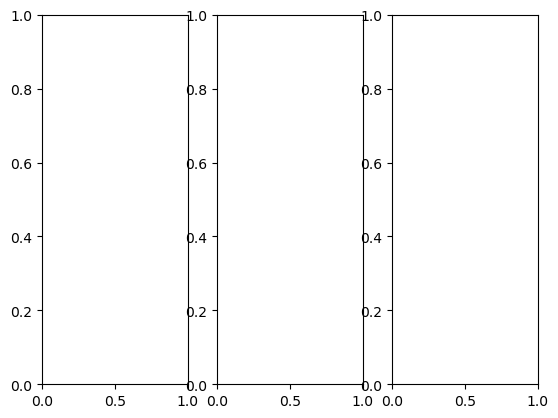

In [23]:
mylist = [i for i in range(100)]

counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 3) # initialize 3 subplots

# set global parameters for DGP
beta = 1
pi = np.array([[1]])

for N in [100, 1000, 10000]:
    # calculate IV a bunch of times
    beta_hats = [monteCarloBeta(N, beta, pi).item() for i in range(1000)] #needs to be modified to only return out the betas. right now monteCarlo produces both beta hat and se hat. we still need se hat 
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"N = {N}")
    ax[counter].axvline(x=1, color='r', label='True beta')
    
    #not sure yet how to integrate the part about 95% CI - it's in the code above, though

    # advance counter
    counter = counter + 1

In [11]:
#Problem 2.C

In [17]:
#Q3
#Alter DGP to now return Z as an n x l matrix with successive columns of Z increasingly "weak" instruments
def dgp_weak(N, beta, pi):
    '''
    Data-generating process
    
    Inputs
    ------
    N (int) number of obervations
    beta (float) true parameter
    pi (lx1 np.array) tur first stage parameter
 
    Returns
    -------
    y (Nx1 np.array)
    x (Nx1 np.array)
    Z (Nxl np.array)
    '''
     # infer number of instruments from the size of pi-l
    l = pi.shape[0]
    
    #we use pi_l for the sequence where successive numbers are half the preceding value
    pi_l = np.array([1 / (2**i) for i in range(1, l+1)]) #issue here- breaks
    
    # generate Z
    Z = stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    
    # generate X - replace with pi_l
    X = Z @ pi_l + stats.norm().rvs(size=(N,1))
    
    # generate y
    y = X * beta + stats.norm().rvs(size=(N,1))
    
    return y, X, Z

N = 5
beta = 2
pi = np.array([[1, 2]])
dgp(N, beta, pi)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 5)

In [ ]:
#3a


In [ ]:
#3b